# Training Neural Networks to Emulate Audio Effects

I'm gearing up to start a new job at an AI lab, working on RL systems, and I want to do a bit of hands-on NN work to get a sense for what a researcher workflow might look like.

Let's figure out how to train a model to emulate various audio effects, like distortion units or reverbs or whatever. For boilerplate stuff like loading audio data, I'll write a type signature and comment and have Claude fill out the details. For the core training/algo stuff I'll write it myself.

I've barely read any neural network literature at this point. Basically everything I know about NNs is just from discussions with [my friend who works on neural compression codecs](https://danjacobellis.net). I'll probably do some stupid stuff here, call things by the wrong name, etc., but I find it's often more educational to go in blind and try to figure things out yourself.

I figure an architecture that might work pretty well is to have the previous `m` input samples, $[i_n, i_{n+1}, ..., i_{n+m-1}, i_{n+m}]$, and the previous `m-1` output samples, $[o_n, o_{n+1}, ..., o_{n+m-1}]$, and train the network to generate the next output sample, $o_{n+m}$

```
                     .-------.
[m prev inputs]----->|  The  |
[m-1 prev outputs]-->| Model |-->[next output]
                     '-------'
```

This architecture seems good to me because:

1. It's easy to generate examples of input data where we can train the model 1 sample at a time
2. It gives the model enough context to (theoretically) recover information like "what is the current phase of this oscillator"


As for how to actually represent the audio, some initial thoughts:

1. You could just pass in and extract straight up $[-1,1]$ float audio into/out of the model.
   1. The model will have to grow hardware to implement a threshold detector ADC or something, which seems kind of wasteful
   2. This fails to accurately capture entropy density in human audio perception. A signal with peak amplitude 0.01 is often just as clear to humans as a signal with peak amplitude 1.0. Which brings us to a possible improvement
2. Pre- and post-process the audio with some sort of compander, like a $\mu$-law
   1. This will probably help the model maintain perceptual accuracy across wide volume ranges
3. Encode a binary representation of the audio. This feels to me like it will probably be difficult for the model to reason about.
4. Use some sort of one-hot encoding for the amplitude, probably in combination with a companding algorithm. This might be too expensive on the input side (since we have a lot of inputs), but could work well on the output side. We could have 256 different outputs for 8-bit audio, for example.
   1. We could also possibly allow the network to output a continuous "residual" value for adding additional accuracy on top of the one-hot value.
  
For now, let's just try the first thing and see how it goes. I expect it will work OK for well-normalized (loud) audio and poorly for quiet audio.

As for our loss function: probably some sort of perceptual similarity metric would be best, followe by a super simple perceptual-ish metric like squared error in $\mu$-law space. However, to start with, let's just do linear mean squared error. Should be OK for loud audio.

First up, I need a bunch of training data. I took a bunch of songs from my music library and put them in the `examples` folder. (I'm old enought that I have about 75GB of local music files.) 

When we want to train a new effect, we'll have a bunch of training runs of the form:

1. Pick a bunch of random song slices from the library
2. Feed the song slices through the reference implementation of the effect (could be software or hardware)
3. Train the model to predict the next sample of the effect across all I/O examples in the batch

## Initial Setup: Loading example audio, slicing example data

In [3]:
import os
import numpy as np
import torchaudio
import random
from pathlib import Path
from typing import List, Tuple

# Mostly courtesy of Claude

def list_audio_files(examples_dir: str = "examples") -> List[str]:
    """
    List all audio files in the examples directory.
    """
    # m4a doesn't work for some reason
    audio_extensions = {'.mp3','.wav', '.flac', '.aac', '.ogg', '.mp4'}
    audio_files = []
    
    examples_path = Path(examples_dir)
    if not examples_path.exists():
        raise FileNotFoundError(f"Examples directory '{examples_dir}' not found")
    
    for file_path in examples_path.rglob('*'):
        if file_path.is_file() and file_path.suffix.lower() in audio_extensions:
            audio_files.append(str(file_path))
    
    return sorted(audio_files)

def read_audio_normalized(file_path: str) -> np.ndarray:
    """
    Read an audio file, convert to mono, and normalize so peak absolute value is 1.0.
    """
    # Load audio using torchaudio (handles many formats)
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        
        # Convert to numpy float32
        audio = waveform.numpy().astype(np.float32)
        
        # Convert to mono by averaging channels if stereo/multi-channel
        if audio.shape[0] > 1:
            audio = np.mean(audio, axis=0)
        else:
            audio = audio.squeeze(0)
        
        # Normalize to peak amplitude of 1.0
        peak = np.max(np.abs(audio))
        if peak > 0:  # Avoid division by zero for silent audio
            audio = audio / peak
            
        return audio
        
    except Exception as e:
        raise RuntimeError(f"Failed to load audio file '{file_path}': {str(e)}")

OK, now let's write some code to generate input/output data for training the network.

Our input tensor will be of shape `(batch size, m input samples + m-1 output samples)` and our output tensor will
be of shape `(batch size, 1)`.

First, load some example audio:

In [4]:
from IPython.display import clear_output

def load_some_audio_files(file_count : int) -> List[np.ndarray]:
    """
    Pick some random audio files from disk to load into memory
    """
    audio_files = list_audio_files()
    
    if len(audio_files) < file_count:
        raise ValueError(f"Not enough audio files: found {len(audio_files)}, need {file_count}")
    
    # Sample random files without replacement
    selected_files = random.sample(audio_files, file_count)
    
    audios = []
    failed_files = []
    
    for file_path in selected_files:
        try:
            # Read and normalize the dry audio
            dry_audio = read_audio_normalized(file_path)
            audios.append(dry_audio)
            
        except Exception as e:
            failed_files.append((file_path, str(e)))
            print(f"Warning: Failed to process {file_path}: {e}")
    
    if failed_files and len(audios) == 0:
        raise RuntimeError(f"All audio files failed to process: {failed_files}")
    
    print(f"Successfully processed {len(audios)} audio files ({len(failed_files)} failed)")
    return audios

dry_audio = load_some_audio_files(128)

# We get a bunch of spam about our loader seeing issues in certain files. Not important
clear_output()

Then, a function that takes unprocessed/processed examples and slices them up into lots of little slices for the model to train on:

In [5]:
def generate_slices_from_pairs(audio_pairs: List[Tuple[np.ndarray, np.ndarray]],
                               context_window: int,
                               slices_per_pair: int
                               ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given reference input/output dry/wet audio pairs,
    create numpy arrays suitable for training the neural network.
    Will generate randomly-selected slices from each audio pair.

    Args:
        audio_pairs: A list of (dry,wet) mono audio arrays (entire processed songs)
        context_window: The number of historical input samples the neural network gets
        slices_per_pair: The number of example slices we want for each input/output pair

    Returns:
        Tuple of (input_features, target_outputs):
        - input_features: f32 array of shape (total_slices, context_window * 2 - 1)
            Each row contains `context_window` input samples concatenated with 
            `context_window - 1` previous output samples
        - target_outputs: f32 array of shape (total_slices, 1)
            The next output sample corresponding to each input block
            
    Raises:
        ValueError: If audio pairs are too short for the context window
    """
    if not audio_pairs:
        raise ValueError("No audio pairs provided")
    
    total_slices = len(audio_pairs) * slices_per_pair
    feature_size = context_window * 2 - 1
    
    # Pre-allocate output arrays
    input_features = np.zeros((total_slices, feature_size), dtype=np.float32)
    target_outputs = np.zeros((total_slices, 1), dtype=np.float32)
    
    slice_idx = 0
    
    for dry_audio, wet_audio in audio_pairs:
        # Check minimum length requirement
        min_length = context_window * 2  # Need context_window for input + context_window for output history + 1 for target
        if len(dry_audio) < min_length:
            print(f"Warning: Audio pair too short ({len(dry_audio)} samples), need at least {min_length}. Skipping.")
            continue
            
        # Generate random slice positions for this pair
        # Valid range: from context_window to len-1 (need context_window previous samples)
        max_start = len(dry_audio) - context_window
        slice_positions = np.random.randint(context_window, max_start + 1, size=slices_per_pair)
        
        for pos in slice_positions:
            # Extract input context: previous context_window input samples
            input_context = dry_audio[pos - context_window:pos]
            
            # Extract output context: previous context_window-1 output samples  
            output_context = wet_audio[pos - context_window:pos - 1]
            
            # Combine input and output contexts
            input_features[slice_idx] = np.concatenate([input_context, output_context])
            
            # Target is the next output sample
            target_outputs[slice_idx, 0] = wet_audio[pos]
            
            slice_idx += 1
    
    # Trim arrays if some pairs were skipped
    if slice_idx < total_slices:
        input_features = input_features[:slice_idx]
        target_outputs = target_outputs[:slice_idx]
        print(f"Generated {slice_idx} slices (some audio pairs were too short)")
    else:
        print(f"Generated {slice_idx} slices from {len(audio_pairs)} audio pairs")
    
    return input_features, target_outputs

## The Model

Let's define a model with an input layer, 5 middle layers, and an output layer that maps down to a scalar. GELU between layers.

In [24]:
import torch
import matplotlib.pyplot as plt

# Each inner layer is this wide
inner_layer_size = 256
num_inner_layers = 5

class Model:
    def __init__(self, input_layer, input_biases, inner_layers, inner_biases, output_layer, output_bias, device):
        self.input_layer, self.input_biases, self.inner_layers, self.inner_biases, self.output_layer, self.output_bias = \
            input_layer, input_biases, inner_layers, inner_biases, output_layer, output_bias
        self.device = device
    def eval(self, inputs):
        # Run the model forward
        vec = torch.nn.functional.gelu(inputs @ self.input_layer + self.input_biases)
        for i,layer in enumerate(self.inner_layers):
            bias = self.inner_biases[i]
            vec = torch.nn.functional.gelu(vec @ layer + bias)
        vec = vec @ self.output_layer + self.output_bias
        return vec
    def to(self, device) -> Model:
        return Model(
           self.input_layer.to(device),
           self.input_biases.to(device),
           [l.to(device) for l in self.inner_layers],
           [l.to(device) for l in self.inner_biases],
           self.output_layer.to(device),
           self.output_bias.to(device),
           device)
    
# Run a model on CPU audio
# This is janky; in production, I would send an N-sample buffer of input audio to the device
# and do the iterative model evaluation there, instead of going back-and-forth on every sample.
# For now, we can just move the model to the CPU and inference is acceptably fast for this notebook
def apply_to_audio(model : Model, audio):
    inputs = np.zeros(context_window).astype('float32')
    prev_outs = np.zeros(context_window - 1).astype('float32')
    outputs = np.zeros(audio.shape).astype('float32')
    for i,sample in enumerate(audio):
        # Shift on the new input sample
        inputs[:-1] = inputs[1:]
        inputs[-1] = sample
        model_input = np.concatenate([inputs, prev_outs])
        with torch.no_grad():
            output = model.eval(torch.from_numpy(model_input).to(model.device)).item()
        # Shift on the new output sample (which we just generated)
        prev_outs[:-1] = prev_outs[1:]
        prev_outs[-1] = output

        # Save the output
        outputs[i] = output
        # print(model_input)
    return outputs

## Training the Model

An issue I ran into during initial training runs: if you pick a bunch of gaussian initial weights, and each layer is a ReLU, you get a bunch of paths through the network where the expected "gain" is extremely large, probably on the order of something like `sqrt(width)^depth` if I had to guess, resulting in insanely large outputs that take a lot of training bandwidth to eliminate (at least with the Adam optimizer). As a hack, I just normalized the weights by `1/sqrt(width)`, which made the training converge quite quickly without having to tamp down excessive outputs.

I imagine some of the "norm" operations I sometimes hear about are used to address this. In any case, the careful selection of initial weights seems to work fine.

In [108]:
batch_size = 1024*16

weight_norm = 1.0/np.sqrt(inner_layer_size)

# Just take the linear MSE of the output vs the reference
def linear_loss(output, reference):
    error = output - reference
    loss = (error ** 2).mean()
    return loss

def train(examples : Tuple[np.ndarray, np.ndarray], epoch_count : int = 100, loss_function = linear_loss) -> Model:
    """
    Train a model on the given input/output examples

    Args:
        examples[0]: A (batch_size, context_window*2-1) tensor of (m prev input, m-1 prev output) pairs
        examples[1]: A (batch_size, 1) tensor of next audio output values
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (GPU) device")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device")
    else:
        device = torch.device("cpu")
        print("Using CPU device")
    training_losses = []
    validation_losses = []
    inputs, outputs = examples
    inputs, outputs = torch.tensor(inputs).to(device), torch.tensor(outputs).to(device)
    validation_inputs, inputs = inputs[:1000], inputs[1000:]
    validation_outputs, outputs = outputs[:1000], outputs[1000:]
    # Input layer maps from the input context to our inner layers
    input_layer = (torch.randn((context_window * 2 - 1, inner_layer_size),device=device) * weight_norm).requires_grad_()
    input_biases = (torch.randn(inner_layer_size, device=device) * weight_norm).requires_grad_()
    # Inner layers do whatever
    inner_layers = [(torch.randn((inner_layer_size, inner_layer_size), device=device) * weight_norm).requires_grad_() for _ in range(num_inner_layers)]
    inner_biases = [(torch.randn(inner_layer_size, device=device) * weight_norm).requires_grad_() for _ in range(num_inner_layers)]
    # Maps from our last layer to the next audio output value
    output_layer = (torch.randn((inner_layer_size, 1), device=device) * weight_norm).requires_grad_()
    output_bias = (torch.randn(1, device=device) * weight_norm).requires_grad_()
    model = Model(input_layer, input_biases, inner_layers, inner_biases, output_layer, output_bias, device)
    # Automatically adjusts learning rate for each param, uses momentum, etc.
    optimizer = torch.optim.Adam([input_layer, input_biases] + inner_layers + inner_biases + [output_layer, output_bias], lr=0.001)
    # Run a bunch of optimization steps
    for epoch in range(epoch_count):
        # Shuffle the training inputs
        num_training_samps, _ = inputs.shape
        epoch_indices = torch.randperm(num_training_samps)
        inputs = inputs[epoch_indices]
        outputs = outputs[epoch_indices]

        # Run a bunch of batches
        epoch_training_losses = []
        num_batches = num_training_samps//batch_size
        for batch in range(num_batches):
            #print(f"batch {batch}/{num_batches}")
            batch_inputs = inputs[batch_size * batch : batch_size * (batch + 1)]
            batch_outputs = outputs[batch_size * batch : batch_size * (batch + 1)]
            # for inputs, outputs in 
            # Reset the gradients on each leaf node
            optimizer.zero_grad()
            # Run the model forward
            vec = model.eval(batch_inputs)
            loss = loss_function(vec, batch_outputs)
            loss.backward()
            epoch_training_losses.append(loss.cpu().item())

        # Record the average training loss
        training_losses.append(np.mean(epoch_training_losses))

        # Calculate the validation lass
        with torch.no_grad():
            vec = model.eval(validation_inputs)
            error = vec - validation_outputs
            loss = (error ** 2).mean()
            validation_losses.append(loss.cpu().item())

        # Update the loss graph
        if True:
            clear_output(wait=True)
            plt.plot(training_losses, 'g')
            plt.plot(validation_losses, 'r')
            plt.yscale('log')
            plt.show()
            
        # Let the optimizer adjust the params
        # Conceptually it's basically doing param -= param.grad * 0.01 for each param
        # But it's doing stuff with momentum, normalization, etc. to make it converge faster
        optimizer.step()
    # Move to CPU because I haven't bothered to make a non-numpy inference loop
    return model.to('cpu')

We'll train the model on a "does nothing" effect that just passes through the audio unchanged. This is a good sanity check that our structure even works.

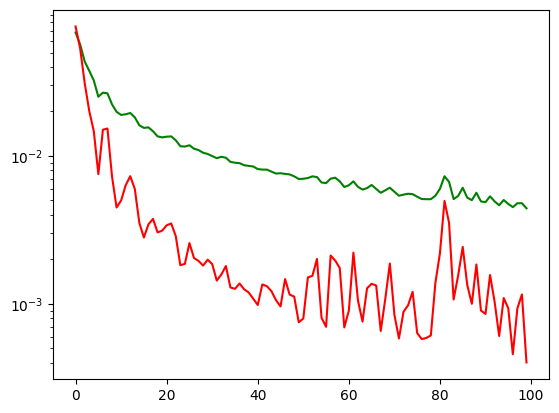

In [26]:
context_window = 128
slices_per_pair = 1024*8

# Do nothing to the audio.
# For now we're just learning how to pass audio through unchanged
passthru_data = generate_slices_from_pairs([(dry, dry) for dry in dry_audio],
                                           context_window, 
                                           slices_per_pair)

clean_model = train(passthru_data, epoch_count = 100)

That actually looks better than I expected with linear IO. On the order of 1% error. Let's listen to it. First, a short clip from some validation data from Emancipator's *1993*.

In [28]:
from IPython.display import Audio
import numpy as np

listen_audio = read_audio_normalized("validation/1993.wav")[:44100]

sample_rate = 44100
Audio(listen_audio, rate=sample_rate)

Let's run it through the model.

In [29]:
clean_processed = apply_to_audio(clean_model, listen_audio)
Audio(clean_processed, rate=sample_rate)

Wow, nice! That actually sounds pretty close. A little noisy, as expected. As long as we're happy with only handling loud audio, we don't even need to deal with companding or anything.

In [30]:
avg = np.abs(listen_audio).mean()
err = clean_processed - listen_audio
avg_err = np.abs(err).mean()
print(f"Audio average: {avg}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

Audio average: 0.2080584615468979
Average error: 0.013235202059149742
Audio max: 0.9950575232505798
Error max: 0.1307952105998993


## Distortion Effect

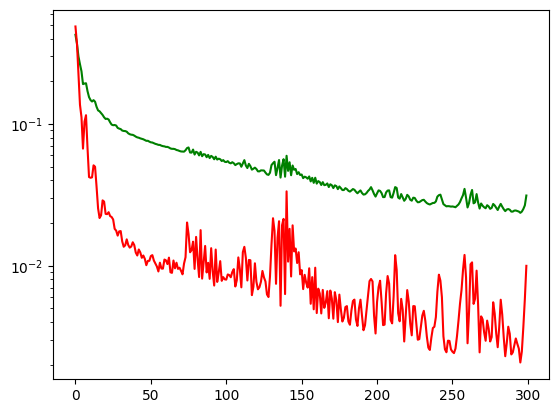

In [43]:
def distort(audio):
    return np.tanh(audio*5)

distort_data = generate_slices_from_pairs([(dry, distort(dry)) for dry in dry_audio],
                                           context_window, 
                                           slices_per_pair)

distort_model = train(distort_data, epoch_count = 300)

In [44]:
Audio(distort(listen_audio), rate=sample_rate)

In [45]:
distort_processed = apply_to_audio(distort_model, listen_audio)
Audio(distort_processed, rate=sample_rate)

In [46]:
avg = np.abs(distort(listen_audio)).mean()
err = distort_processed - distort(listen_audio)
avg_err = np.abs(err).mean()
print(f"Audio average: {avg}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

Audio average: 0.5817455649375916
Average error: 0.5953976511955261
Audio max: 0.9950575232505798
Error max: 1.7954978942871094


Interesting. The average error is quite bad, despite our train-time holdout loss looking reasonable. Let's zoom in on the output and see what's happening.

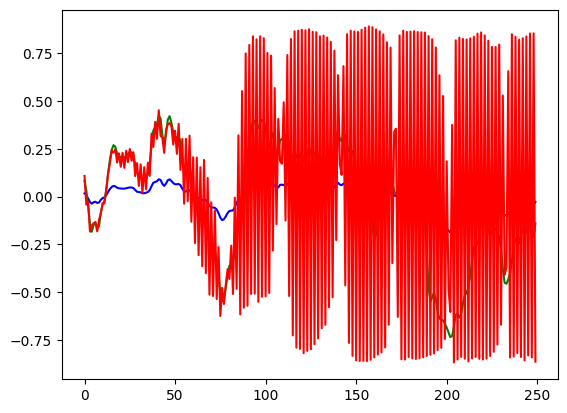

In [53]:
plt.plot(listen_audio[:250],'b')
plt.plot(distort(listen_audio)[:250],'g')
plt.plot(distort_processed[:250], 'r')

Interesting! It starts out tracking the correct value quite nicely, but rapidly starts oscillating about the correct value.

A theory: the model is learning to do something silly with the previous output data, like subtract `out[t-1]` from `in[t-1]`. In the training setup, this difference is always a precise function of the audio effect. But since the network is generating `in` values while we're actually running inference, any error in the network's output could cycle back through the input and could cause wildly divergent behavior.

Let's try making a change to our training setup where we add noise to the previous output values to simulate error on the part of the network.

In [48]:
def add_feedback_noise(examples : Tuple[np.ndarray, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Add some noise to the "previous output" buffer to simulate error on the part of the network during inference.
    """
    (inputs, outputs) = examples
    inputs = inputs.copy()
    inputs[:,context_window:] += np.random.randn(inputs.shape[0], context_window - 1) / 10.0
    return (inputs, outputs)

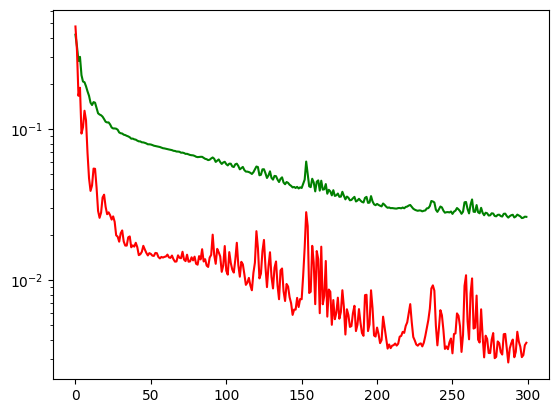

In [49]:
distort_model_2 = train(add_feedback_noise(distort_data), epoch_count = 300)

In [50]:
distort_processed_2 = apply_to_audio(distort_model_2, listen_audio)
Audio(distort_processed_2, rate=sample_rate)

In [51]:
avg = np.abs(distort(listen_audio)).mean()
err = distort_processed_2 - distort(listen_audio)
avg_err = np.abs(err).mean()
print(f"Audio average: {avg}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

Audio average: 0.5817455649375916
Average error: 0.025191348046064377
Audio max: 0.9950575232505798
Error max: 0.5919051766395569


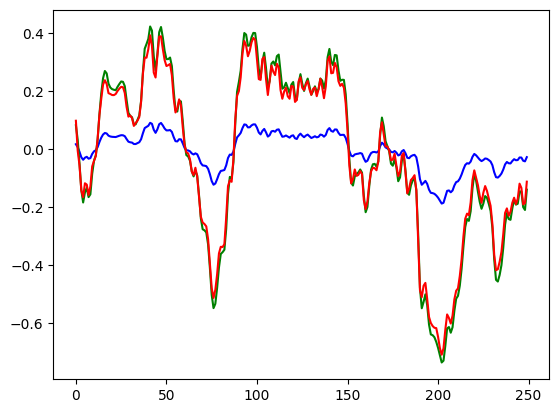

In [79]:
plt.plot(listen_audio[:250],'b')
plt.plot(distort(listen_audio)[:250],'g')
plt.plot(distort_processed_2[:250], 'r')

Bingo! That worked great.

Note that, even though the result is way better, the loss doesn't look much different. This is a shortcoming in our train-time validation step; we only run the audio generation pass once, but if we were setting up proper validation, we'd want to run the audio generation procedure for a bunch of samples in sequence. Hopefully the feedback noise trick is sufficient from here on out.

## Lowpass filter effect

In [67]:
from scipy import signal
from scipy.signal import butter, sosfilt, sosfilt_zi

def lowpass(audio, cutoff_freq, sample_rate, order=4):
    nyquist = sample_rate / 2
    normalized_cutoff = cutoff_freq / nyquist
    sos = butter(order, normalized_cutoff, btype='low', output='sos')
    zi = sosfilt_zi(sos) * audio[0]
    filtered, _ = sosfilt(sos, audio, zi=zi)
    return filtered

In [74]:
lowpass_listen = lowpass(listen_audio, 1000, 44100)
Audio(lowpass_listen, rate=sample_rate)

In [69]:
lowpass_data = generate_slices_from_pairs([(dry, lowpass(dry, 1000, 44100)) for dry in dry_audio],
                                           context_window, 
                                           slices_per_pair)
lowpass_data = add_feedback_noise(lowpass_data)

Generated 1032192 slices from 126 audio pairs


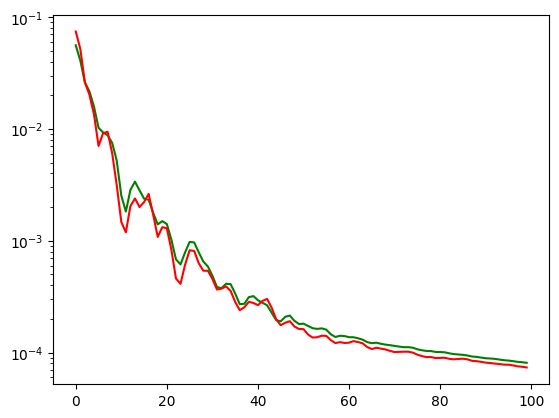

In [71]:
lowpass_model = train(lowpass_data, epoch_count = 100)

Interesting - look how low the error is! My guess is that the network is benefitting from the ability to extract magnitude info from multiple input samples.

In [81]:
lowpass_processed = apply_to_audio(lowpass_model, listen_audio)
Audio(lowpass_processed, rate=sample_rate)

Interesting. It sounds decent, but there's audibly a bit more high-frequency audio leaking through compared to the proper LPF. This is where we'd benefit from using a multi-domain perceptual similarity loss function over a linear per-sample similarity loss function.

In [78]:
avg = np.abs(lowpass_listen).mean()
err = lowpass_processed - lowpass_listen
avg_err = np.abs(err).mean()
print(f"Audio average: {avg}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

Audio average: 0.20593174428118807
Average error: 0.007034474487122566
Audio max: 0.9950575232505798
Error max: 0.054053477027596525


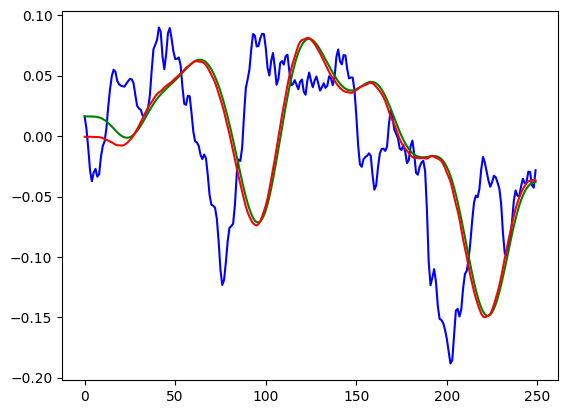

In [80]:
plt.plot(listen_audio[:250],'b')
plt.plot(lowpass_listen[:250],'g')
plt.plot(lowpass_processed[:250], 'r')

Nice tight tracking here. It's not even obvious from the graph that extra high-frequency audio is leaking through.

Overall that worked quite excellently!

# Amplitude Modulation

For our final effect, let's try applying an AM effect to the incoming audio. This will test the model's ability to recover oscillator phase information from the I/O history input structure we're feeding it. At every sample, it has to look at the input and output and figure out where in the AM cycle it currently is.

In [90]:
def amplitude_modulate(audio, freq, sample_rate):
    time = np.linspace(0, audio.shape[0] / sample_rate, audio.shape[0])
    amplitude = np.sin(time * 2 * np.pi * freq)
    return audio * amplitude

In [91]:
am_listen = amplitude_modulate(listen_audio, 1000, sample_rate)
Audio(am_listen, rate=sample_rate)

In [92]:
am_data = generate_slices_from_pairs([(dry, amplitude_modulate(dry, 1000, 44100)) for dry in dry_audio],
                                           context_window, 
                                           slices_per_pair)
am_data = add_feedback_noise(am_data)

Generated 1032192 slices from 126 audio pairs


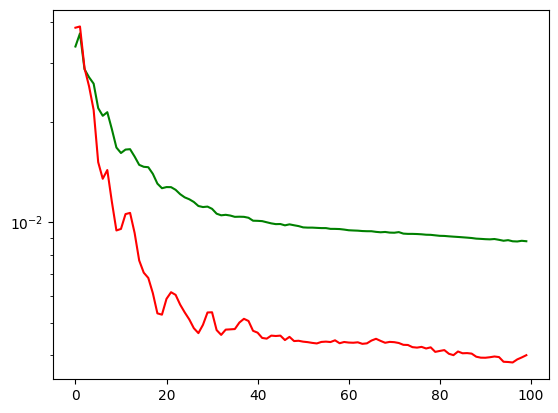

In [95]:
am_model = train(am_data, epoch_count = 100)

In [97]:
am_processed = apply_to_audio(am_model, listen_audio)
Audio(am_processed, rate=sample_rate)

In [104]:
avg = np.abs(am_listen).mean()
err = am_processed - am_listen
avg_err = np.abs(err).mean()
print(f"Reference average: {avg}")
print(f"Processed average: {np.abs(am_processed).mean()}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

Reference average: 0.132379934093374
Processed average: 0.050923384726047516
Average error: 0.147680477674249
Audio max: 0.9950575232505798
Error max: 1.6759739564181175


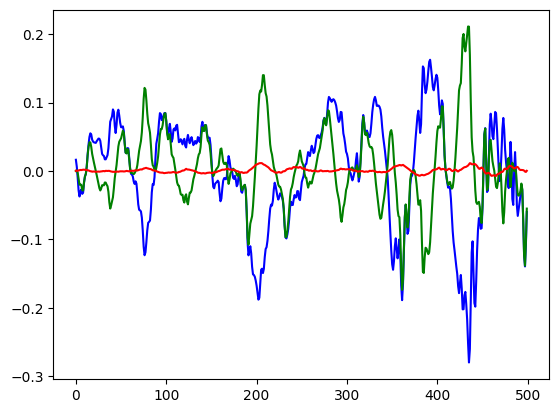

In [103]:
plt.plot(listen_audio[:500],'b')
plt.plot(am_listen[:500],'g')
plt.plot(am_processed[:500], 'r')

Well, that's not very good! It looks like the model is learning to output very quiet audio.

This isn't terribly surprising; if the audio is whipsawing back-and-forth rapidly, the network can probably keep its loss somewhat low by just staying close to zero.

This may be a good opportunity to try out a more perceptual loss function that penalizes magnitude differences rather than linear differences.

In [114]:
# We want to assign a large loss to 0.01 vs 0.02, but a small loss to 0.11 vs 0.12
def magnitude_sensitive_loss(output, reference):
    delta = output - reference 
    scale = output**2 + reference**2 + 0.001
    error = delta**2 / scale
    loss = error.mean()
    return loss

example_in = [0.0, 0.0, 0.0, 0.01, 0.01, 0.1, 0.1]
example_out = [0.0, 0.01, 0.1, 0.02, -0.01, 0.11, 0.12]
for i,in_  in enumerate(example_in):
    out = example_out[i]
    in_ = np.array([in_])
    out = np.array([out])
    loss = magnitude_sensitive_loss(out, in_)
    print(f"i:{in_} o:{out} loss:{loss}")

i:[0.] o:[0.] loss:0.0
i:[0.] o:[0.01] loss:0.09090909090909091
i:[0.] o:[0.1] loss:0.9090909090909091
i:[0.01] o:[0.02] loss:0.06666666666666667
i:[0.01] o:[-0.01] loss:0.3333333333333333
i:[0.1] o:[0.11] loss:0.004329004329004324
i:[0.1] o:[0.12] loss:0.015748031496062975


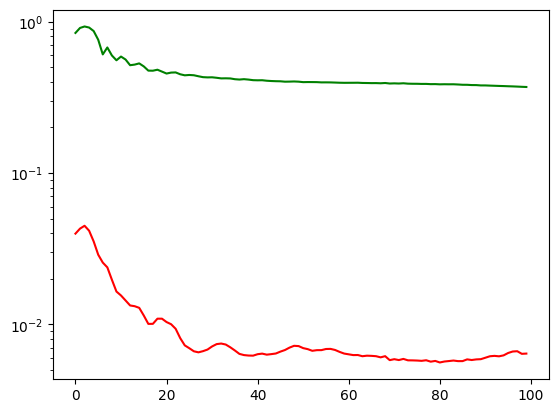

In [115]:
am_model_2 = train(am_data, epoch_count = 100, loss_function = magnitude_sensitive_loss)

In [116]:
am_processed_2 = apply_to_audio(am_model_2, listen_audio)
Audio(am_processed_2, rate=sample_rate)

In [118]:
avg = np.abs(am_listen).mean()
err = am_processed_2 - am_listen
avg_err = np.abs(err).mean()
print(f"Reference average: {avg}")
print(f"Processed average: {np.abs(am_processed_2).mean()}")
print(f"Average error: {avg_err}")
print(f"Audio max: {listen_audio.max()}")
print(f"Error max: {err.max()}")

Reference average: 0.132379934093374
Processed average: 0.05468782037496567
Average error: 0.1559515011580676
Audio max: 0.9950575232505798
Error max: 2.184720837257948


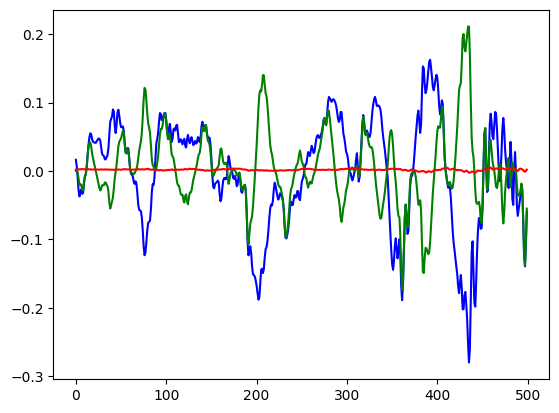

In [119]:
plt.plot(listen_audio[:500],'b')
plt.plot(am_listen[:500],'g')
plt.plot(am_processed_2[:500], 'r')